In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
#import PyPDF2
from skimage.transform import hough_line
from skimage.feature import canny
from matplotlib import cm
from scipy import ndimage as ndi
from skimage import feature
from skimage import filters
from skimage import measure
import skimage
from pdf2image import convert_from_path

from scipy import spatial
from skimage.transform import resize
from skimage.measure import regionprops
import os

# Đọc dữ liệu từ file pdf

In [38]:
pages = convert_from_path('DiemthiKTHP.pdf')
#pages = convert_from_path('DiemthiQT.pdf')

In [28]:
def convert_to_image_gray(page):
    pix = np.array(page.getdata()).reshape(page.size[0], page.size[1], 3)
    #pix = np.array(page.getdata()).reshape(page.size[0], page.size[1], 3)
    #image= 0.2125*pix[:,:,0] + 0.7154*pix[:,:,1] + 0.0721*pix[:,:,2] 
    #image=cv2.cvtColor(pix, cv2.COLOR_BGR2GRAY)
    image=pix[:,:,0]
    return image

In [39]:
image=convert_to_image_gray(pages[0])

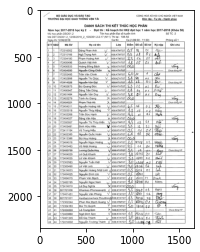

In [40]:
plt.imshow(pages[0])

In [54]:
#skimage.feature.corner.corner_subpix(image, corners, window_size=11, alpha=0.99)
#skimage.feature.corner.corner_shi_tomasi(image, sigma=1)
#skimage.feature.corner.corner_harris(image, method='k', k=0.05, eps=1e-06, sigma=1)


from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.feature.corner import corner_shi_tomasi

In [58]:
corner=corner_peaks(corner_harris(image), min_distance=10)

In [50]:
len(corner)

7132

In [61]:
corner2=corner_subpix(image,corner, window_size=400, alpha=0.99)

C:\Users\tvlon\anaconda3\lib\site-packages\skimage\feature\corner.py:949: RuntimeWarning: overflow encountered in long_scalars
  b_dot[:] = bxx_y - bxy_x, byy_x - bxy_y


In [60]:
len(corner2)

7132

In [51]:
corner[0]

array([1067, 1714], dtype=int64)

In [55]:
corner=corner_shi_tomasi(image,sigma=1)

In [56]:
len(corner)

1654

In [20]:
# Find contours at a constant value of 0.8
contours = measure.find_contours(image, 125)

In [7]:
def area_contour(c):
    cmin=c.min(axis=0)
    cmax=c.max(axis=0)
    
    crange=cmax-cmin;
    area=crange[0]*crange[1]
    return area

In [14]:
areacontours=np.zeros(len(contours))

for i in range(len(contours)):
    c=contours[i]
    areacontours[i]=area_contour(c)

In [15]:
n=len(contours)
largest_indices = np.argsort(-1*areacontours)[:n]

In [16]:
largest_indices

array([], dtype=int64)

In [13]:
areacontours

array([], dtype=float64)

In [21]:
len(contours)

0

In [16]:
def extract_letter_and_number(image,path1,path2):
    image=image[::-1,:]
    # Find contours at a constant value of 0.8
    contours = measure.find_contours(image, 125)
    xyacontours=np.zeros( (len(contours),3))
    bcontours=np.zeros( (len(contours),4) )
    for i in range(len(contours)):
        c=contours[i]
        cmin=c.min(axis=0)
        cmax=c.max(axis=0)
        
        bcontours[i][0]=cmin[0]
        bcontours[i][1]=cmin[1]
        bcontours[i][2]=cmax[0]
        bcontours[i][3]=cmax[1]
        
        crange=cmax-cmin;
        area=crange[0]*crange[1]
        xyacontours[i][0]=crange[0]
        xyacontours[i][1]=crange[1]
        xyacontours[i][2]=area
        df=pd.DataFrame(data=xyacontours,columns=['x','y','area'])
        # filter
        df1=df[ (df['x']<=45 )& (df['x']>=4) & ( df['y']<=50) & (df['y']>=10) & (df['area']>=100 ) ]
    
        filter_contours=df1.index
        for i in filter_contours:
            indices=i
            #c=contours[indices]
            b=bcontours[indices].astype(np.int)
            imc=image[b[0]-2:b[2]+2,b[1]-2:b[3]+2][::-1,:]
            #dim = (20, 20)
            # resize image
            #imc_resized = cv2.resize(imc, dim, interpolation = cv2.INTER_NEAREST)
            #cv2.imwrite(path+str(i)+".png", imc_resized)
            cv2.imwrite(path2+str(i)+".png", imc)

In [18]:
for i in range(len(pages)):
    path1="datasets/page_"+str(i+1)
    path2=path1+"/p"+str(i+1)+"_id_"
    os.mkdir(path1)
    image=convert_to_image_gray(pages[i])
    extract_letter_and_number(image,path1,path2)
    

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgcodecs\src\loadsave.cpp:803: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


# Chuyển file pdf sang ma trận ảnh đen trắng

In [3]:
def convert_to_image_gray(page):
    pix = np.array(page.getdata()).reshape(page.size[1], page.size[0], 3)
    #pix = np.array(page.getdata()).reshape(page.size[0], page.size[1], 3)
    image=pix[:,:,0]
    return image
def convert_to_binary(image):
    binary=image/image.max()
    b=np.round(binary).astype('int')
    return b
def compute_cross(a,b,c,d,w,im,th): # range [a,b]x[c,d]
    n=im.shape[0]
    m=im.shape[1]
    cross=[]
    for x in range(a,b):
        for y in range(c,d):
            #(ec,nc,wc,sc)=zeros_cross(x,y,window,binary)
            l=int(max(0,y-w))
            r=int(min(y+w,m))
            b=int(max(0,x-w))
            t=int(min(x+w,n))           
            
            #print(r,b,l,t)
            ec=im[x,y:r].sum()
            if ec<=th:
                wc=im[x,l:y].sum()
                if wc<=th:
                    nc=im[b:x,y].sum()
                    if nc<=th:
                        #sc=im[x:t,y].sum()
                        #if sc<=th:
                            #cross.append([x,y,ec,nc,wc,sc])
                        cross.append([x,y])
            
            #if max(ec,nc,wc,sc)<=ths:
            #    cross.append([x,y,ec,nc,wc,sc])
    df=pd.DataFrame(cross)
    return df

def compute_grid_points(grids):
    tree = spatial.KDTree(grids)
    radius=10
    groups=[]
    remainder=set(range(len(grids)))

    while len(remainder)>0:
        idx=remainder.pop()
        lx=tree.query_ball_point(grids.iloc[idx], radius)
        remainder=remainder.difference(set(lx))
        groups.append(list(lx))

    gd=[]
    for i in range(len(groups)):
        l=groups[i]
        xy=grids.iloc[l].mean(axis=0).astype(int)
        gd.append(list(xy))

    dfg=pd.DataFrame(gd)
    return dfg
def split_grid_1dpoints(y):
    diffy=np.zeros(len(y)-1)
    for i in range(len(y)-1):
        diffy[i]=y[i+1]-y[i]
    
    yid=[0]
    for i in range(len(diffy)):
        if diffy[i]>10:
            yid.append(i+1)
    yid.append(len(y))
    
    gpy=[]
    for i in range(len(yid)-1):
        gpy.append(y[yid[i]:yid[i+1]])
    return gpy

def split_grid_points(dfg):
    y=np.sort(dfg[1].unique())
    x=np.sort(dfg[0].unique())
    
    gpy=split_grid_1dpoints(y)
    
    gpx=split_grid_1dpoints(x)
    
    gpy=[gpy[0],gpy[1]]
    
    markcell=np.zeros((len(gpx),len(gpy),2))
    for i in range(len(gpx)):
        for j in range(len(gpy)):
            xmin=gpx[i].min()
            xmax=gpx[i].max()
            ymin=gpy[j].min()
            ymax=gpy[j].max()
            xy=dfg[(dfg[0]>=xmin)&(dfg[0]<=xmax)&(dfg[1]>=ymin)&(dfg[1]<=ymax)].values[0]
            markcell[i,j]=xy
    
    ncells=len(markcell)-1
    cells=np.zeros((ncells,2,2))
    for i in range(ncells):
        cells[i][0]=markcell[i,0]
        cells[i][1]=markcell[i+1,1]
        
    return cells
def computing_cells(a,b,c,d, w,im,th):
    df=compute_cross(a,b,c,d,w,im,th)
    dfg=compute_grid_points(df)
    cells=split_grid_points(dfg)
    return cells

In [4]:
image=convert_to_image_gray(pages[0])

In [5]:
image.shape

(2338, 1654)

## Line Detection

In [412]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line


In [417]:
# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2,50, endpoint=False)
h, theta, d = hough_line(image)#, theta=tested_angles)

In [414]:
angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

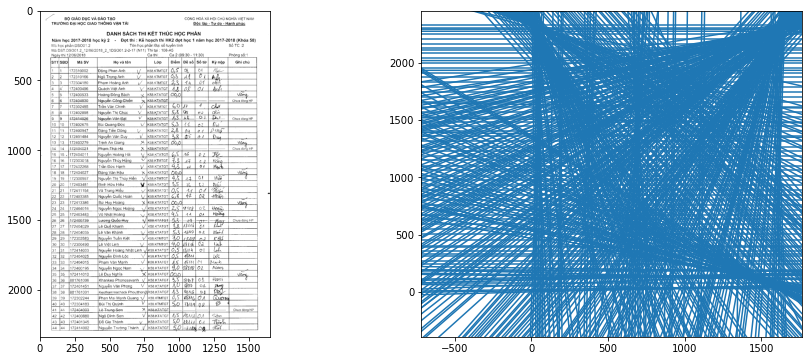

In [415]:
# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(image ,cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    axes[1].axline((x0, y0), slope=np.tan(angle + np.pi/2))
plt.show()

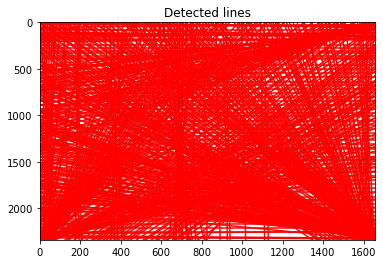

In [416]:
row1, col1 = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    plt.plot((0, col1), (y0, y1), '-r')
plt.axis((0, col1, row1, 0))
plt.title('Detected lines')
plt.show()

In [430]:
edges1 = canny(image,sigma=10)

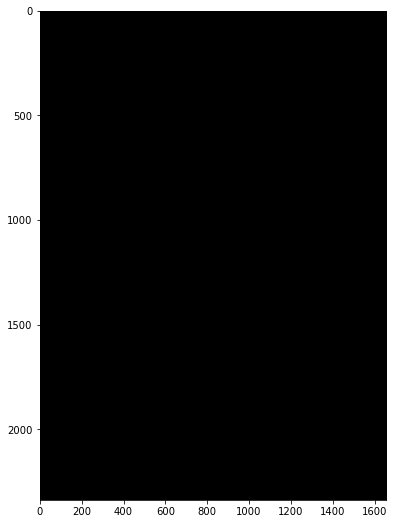

In [431]:
plt.figure(figsize=(16,9))
plt.imshow(edges1, cmap='gray')
plt.show()

# FIND COUNTOURS

In [6]:
from skimage import measure

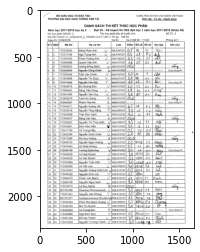

In [8]:
plt.imshow(image,cmap=plt.cm.gray)

In [12]:
# Doi truc x cua anh
image=image[::-1,:]

In [13]:
# Find contours at a constant value of 0.8
contours = measure.find_contours(image, 125)

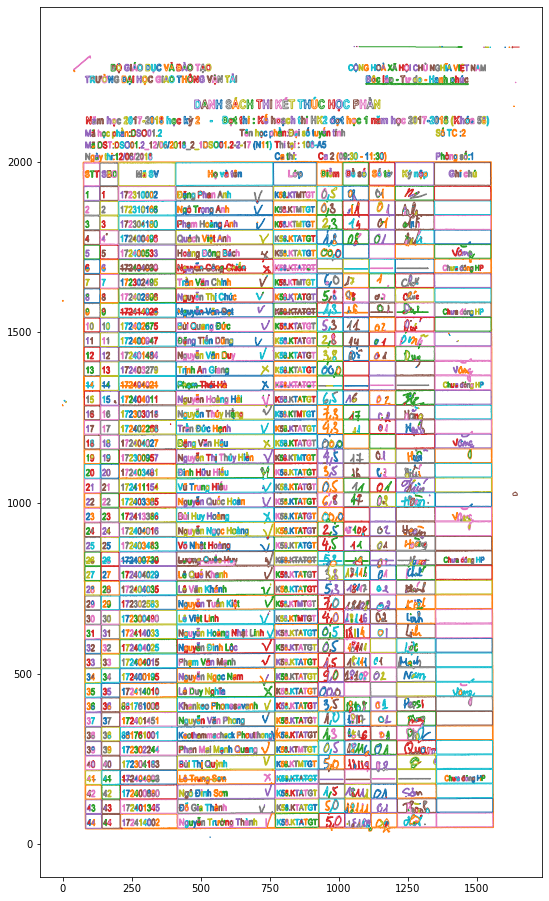

In [16]:
fig, ax = plt.subplots(figsize=(9,16))
#ax.imshow(image, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
plt.show()

In [17]:
len(contours)

4111

## Tinh dien tich cac contour

In [18]:
c=contours[0]

In [42]:
bcontours=np.zeros( (len(contours),4) )

In [25]:
def area_contour(c):
    cmin=c.min(axis=0)
    cmax=c.max(axis=0)
    
    crange=cmax-cmin;
    area=crange[0]*crange[1]
    return area

In [126]:
xyacontours=np.zeros( (len(contours),3))
for i in range(len(contours)):
    c=contours[i]
    cmin=c.min(axis=0)
    cmax=c.max(axis=0)
    crange=cmax-cmin;
    area=crange[0]*crange[1]
    xyacontours[i][0]=crange[0]
    xyacontours[i][1]=crange[1]
    xyacontours[i][2]=area
    


In [127]:
df=pd.DataFrame(data=xyacontours,columns=['x','y','area'])

In [128]:
df.head()

x            y          area
0     0.645833     0.645833  4.171007e-01
1  1991.474448  1485.980392  2.959292e+06
2     7.855354     7.031496  5.523489e+01
3     2.474448     2.953002  7.307050e+00
4    41.019608    57.525552  2.359676e+03

In [156]:
# filter
df1=df[ (df['x']<=40 )& (df['x']>=5) & ( df['y']<=40) & (df['y']>=5) & (df['area']>=100 ) ]

In [157]:
df1.head()

x          y        area
9   20.474448  13.474448  275.881886
10  19.968504  11.968504  238.993118
24  17.525552  12.525552  219.517211
25  20.980392  13.474448  282.699204
26  30.144646  23.980392  722.880441

In [158]:
filter_contours=df1.index

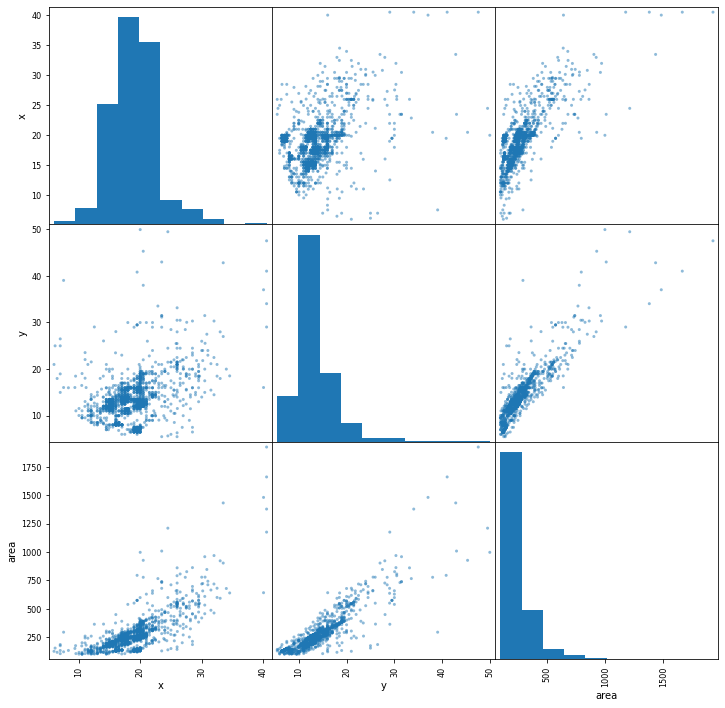

In [151]:
pd.plotting.scatter_matrix(df1,figsize=(12,12))
plt.show()

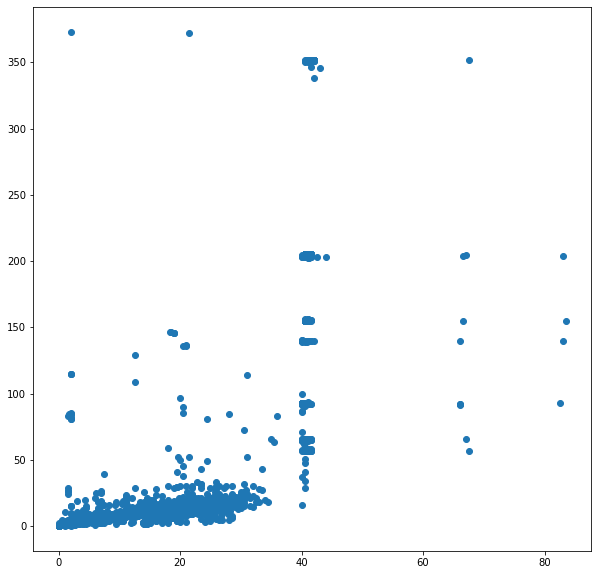

In [111]:
plt.figure(figsize=(10,10))
plt.scatter(rangecontours[2:,0],rangecontours[2:,1],marker='o')
plt.show()

In [123]:
rangexy=np.zeros( (len(contours),2))
for i in range(len(contours)):
    c=contours[i]
    cmin=c.min(axis=0)
    cmax=c.max(axis=0)
    crange=cmax-cmin;
    #area=crange[0]*crange[1]
    x=crange[0]
    y=crange[1]
    if( (x>=2) & (x<=40) & (y>=2) & (y<=40) ):
        rangexy[i][0]=crange[0]
        rangexy[i][1]=crange[1]

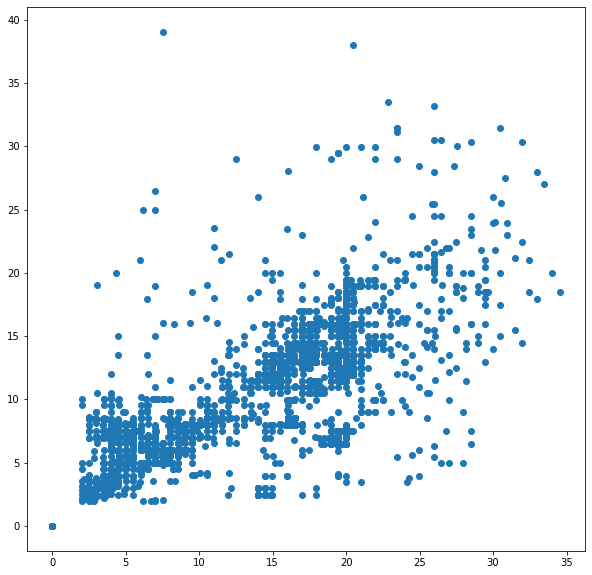

In [124]:
plt.figure(figsize=(10,10))

plt.scatter(rangexy[:,0],rangexy[:,1],marker='o')
plt.show()

In [113]:
xyrange=rangecontours[rangecontours<=40]

In [43]:
areacontours=np.zeros(len(contours))

for i in range(len(contours)):
    c=contours[i]
    cmin=c.min(axis=0)
    cmax=c.max(axis=0)
    crange=cmax-cmin;
    area=crange[0]*crange[1]
    bcontours[i][0]=cmin[0]
    bcontours[i][1]=cmin[1]
    bcontours[i][2]=cmax[0]
    bcontours[i][3]=cmax[1]
    
    areacontours[i]=area
    

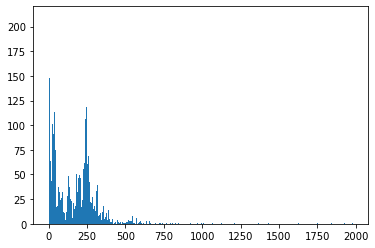

In [125]:
plt.hist(areacontours[areacontours<=2000],bins=500)
plt.show()

In [44]:
n=len(contours)
largest_indices = np.argsort(-1*areacontours)[:n]

In [45]:
largest_indices[:10]

array([   1, 3469, 1485,   16, 1385, 1729,  184,  261,  679, 2410],
      dtype=int64)

In [46]:
bcontours[1]

array([  35.01574803,   74.50980392, 2026.49019608, 1560.49019608])

In [51]:
im=image[::-1,:]

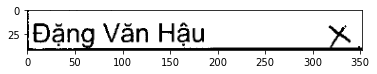

In [168]:

indices=largest_indices[11]
c=contours[indices]
b=bcontours[indices].astype(np.int)

#plt.figure(figsize=(10,10))
imc=image[b[0]:b[2],b[1]:b[3]][::-1,:]
plt.imshow(imc,cmap=plt.cm.gray)
#plt.savefig("datasets/1.png")
plt.imsave(fname='1.png', arr=image[b[0]:b[2],b[1]:b[3]][::-1,:], cmap='gray_r', format='png')
plt.show()

In [172]:
imc[:2,:]

array([[  0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 127, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 127, 255, 255, 255, 255, 255, 255, 255,
        127, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 127, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255

In [99]:

indices=largest_indices[11]
c=contours[indices]
b=bcontours[indices].astype(np.int)

#figure = plt.gcf()
#figure.set_size_inches(b[2]-b[0], b[3]-b[1])

imc=image[b[0]:b[2],b[1]:b[3]][::-1,:]
#plt.imshow(imc,cmap=plt.cm.gray)
#plt.imsave(fname='1.png', arr=imc, cmap='gray_r', format='png')
#plt.savefig("datasets/1.png")
#plt.savefig("sample.png", dpi=100)
cv2.imwrite("datasets/1.png", imc)

True

In [167]:
for i in filter_contours:
    indices=i
    #c=contours[indices]
    b=bcontours[indices].astype(np.int)
    imc=image[b[0]-2:b[2]+2,b[1]-2:b[3]+2][::-1,:]
    dim = (28, 28)
    # resize image
    imc_resized = cv2.resize(imc, dim, interpolation = cv2.INTER_NEAREST)
    cv2.imwrite("datasets/"+str(i)+".png", imc_resized)

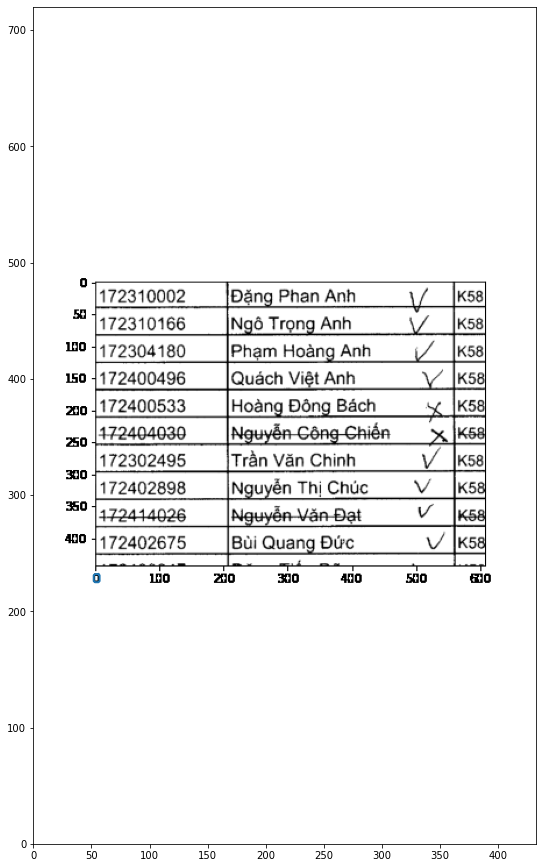

In [546]:
fig, ax = plt.subplots(figsize=(9,16))
ax.imshow(image, cmap=plt.cm.gray)
contour =contours[0]
plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.xlim(0,image.shape[1])
plt.ylim(0,image.shape[0])
plt.show()

In [532]:
contour =contours[0]
contour.min()

35.999607843137255

In [534]:
contour =contours[0]
contour.max(axis=0)

array([2026.00039216, 1560.00039216])

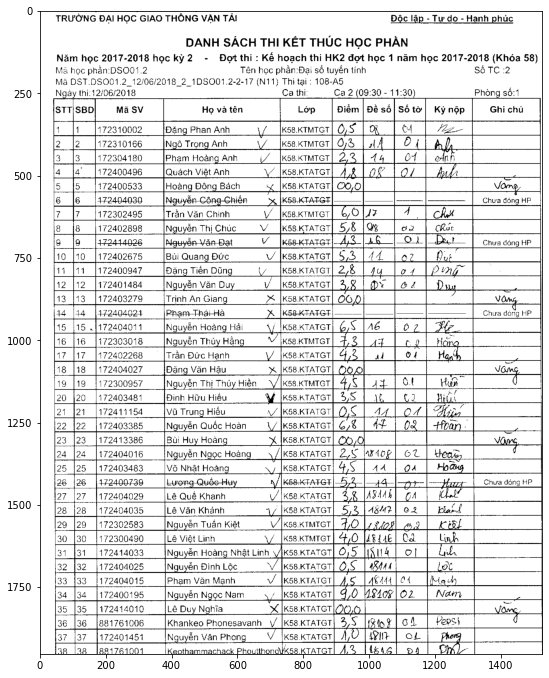

In [536]:
fig, ax = plt.subplots(figsize=(9,16))
plt.imshow(image[::-1,:][74:2026,35:1560], cmap=plt.cm.gray)

plt.show()

In [368]:
def detect_bang_diem(image):
    image[image<10]=0
    image[image>=10]=255
    image_meany=image.mean(axis=0)
    image_meanx=image.mean(axis=1)
    vline_index = np.where(diff(image_meany)<-10)[0]
    hline_index = np.where( diff(diff(image_meanx))>70 )[0]
    areabd=image[hline_index[0]:hline_index[-1],vline_index[0]:vline_index[-1]]
    return areabd

In [364]:
image=convert_to_image_gray(pages[0])

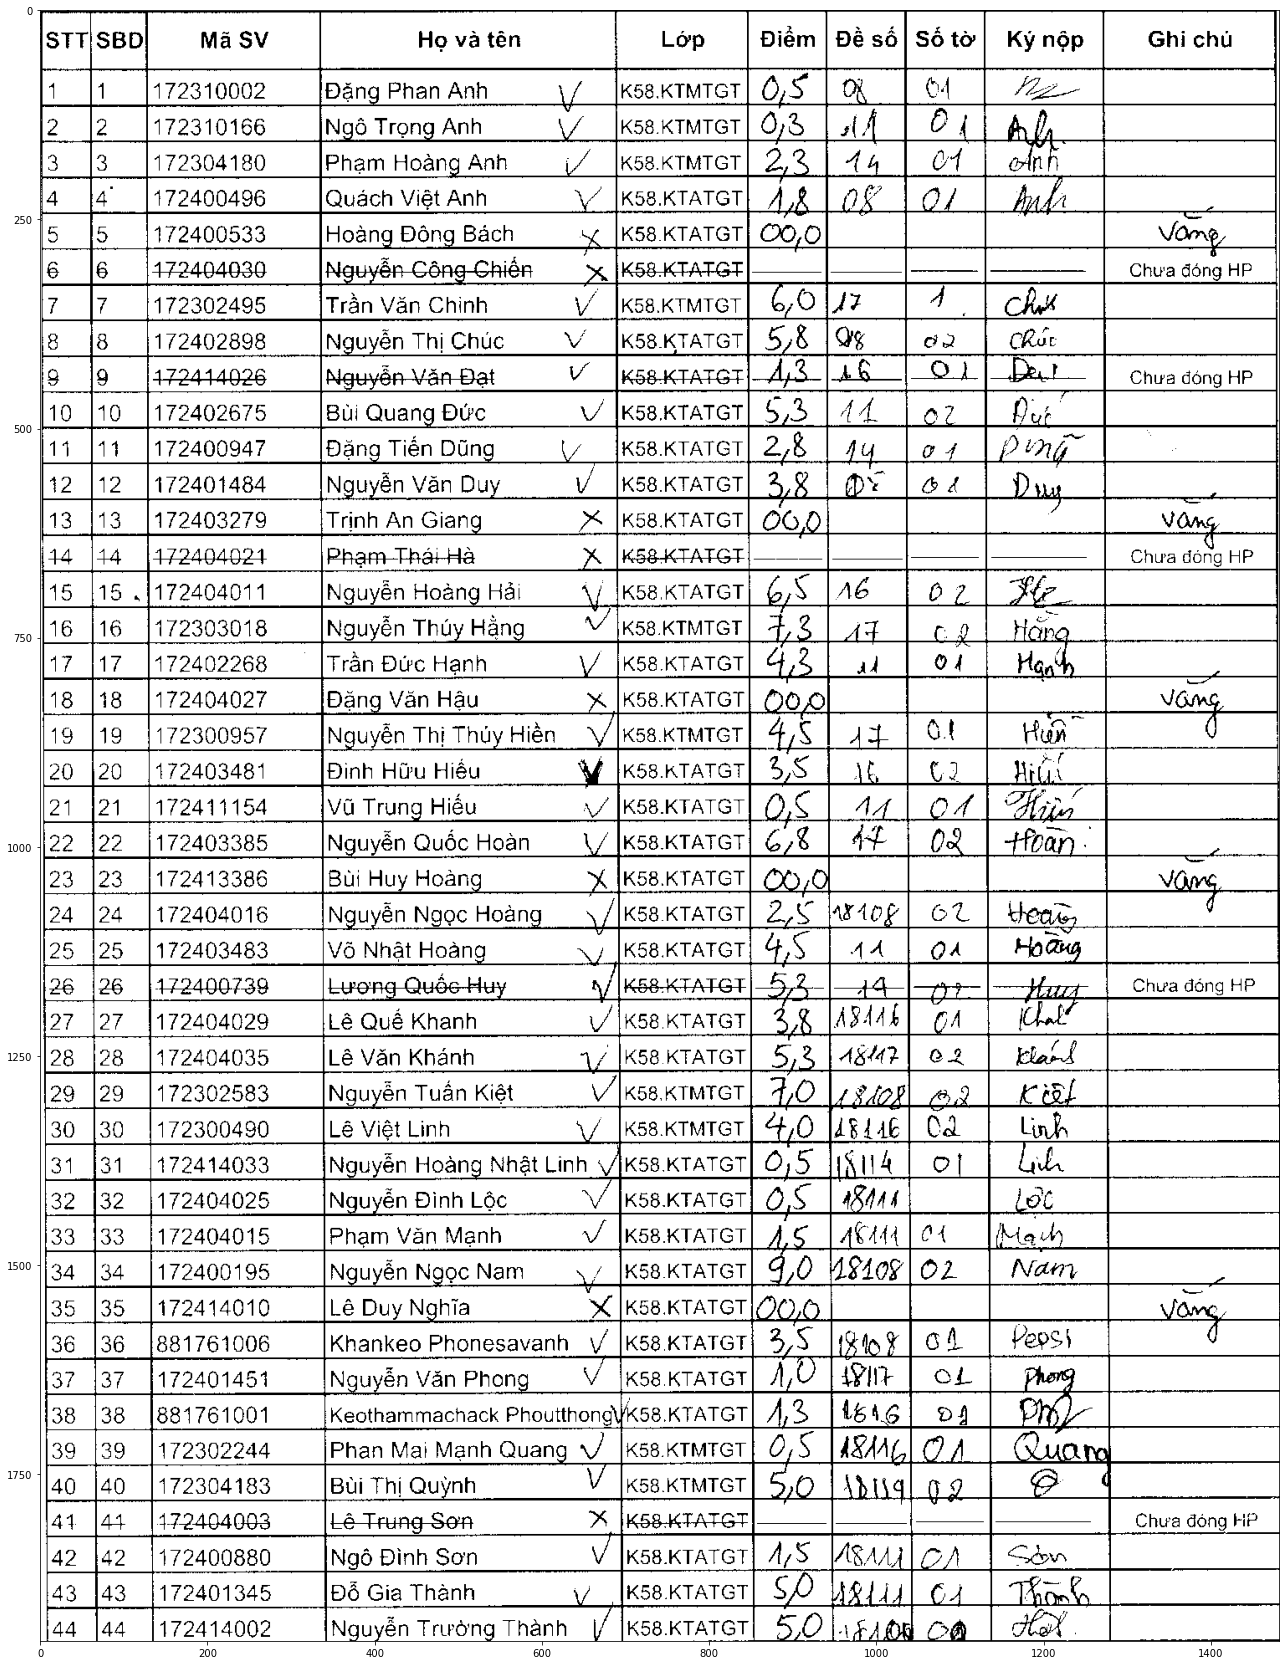

In [369]:
plt.figure(figsize=(36,30))
plt.imshow(detect_bang_diem(image),cmap=cm.gray)
plt.show()

In [336]:
image[image<50]=0
image[image>=50]=255

In [337]:
image_meany=image.mean(axis=0)
image_meanx=image.mean(axis=1)


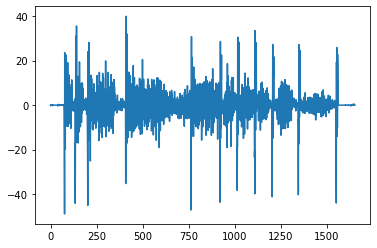

In [338]:
plt.plot(diff(image_meany))

In [339]:
print(np.where(diff(image_meany)<-20)[0][0])
print(np.where(diff(image_meany)<-20)[0][-1])

76
1551


In [340]:
vline_index = np.where(diff(image_meany)<-20)[0]
vline_index

array([  76,  134,  201,  202,  216,  408,  409,  410,  762,  919, 1013,
       1107, 1108, 1109, 1203, 1345, 1550, 1551], dtype=int64)

In [ ]:
image_meanx[image_meanx]

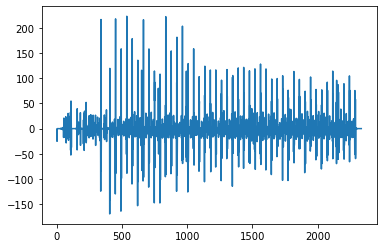

In [343]:
plt.plot(diff(diff(image_meanx)))

In [345]:
print(np.where( diff(diff(image_meanx))>100 )[0][0] )
print(np.where( diff(diff(image_meanx))>100 )[0][-1] )

338
2244


In [346]:
hline_index = np.where( diff(diff(image_meanx))>100 )[0]
hline_index

array([ 338,  406,  407,  450,  492,  493,  536,  578,  620,  621,  650,
        664,  706,  748,  791,  835,  877,  921,  963,  993, 1007, 1049,
       1091, 1135, 1177, 1219, 1305, 1347, 1349, 1391, 1433, 1477, 1519,
       1562, 1604, 1732, 1818, 1946, 2116, 2244], dtype=int64)

In [347]:
areabd=image[338:2244,76:1552]

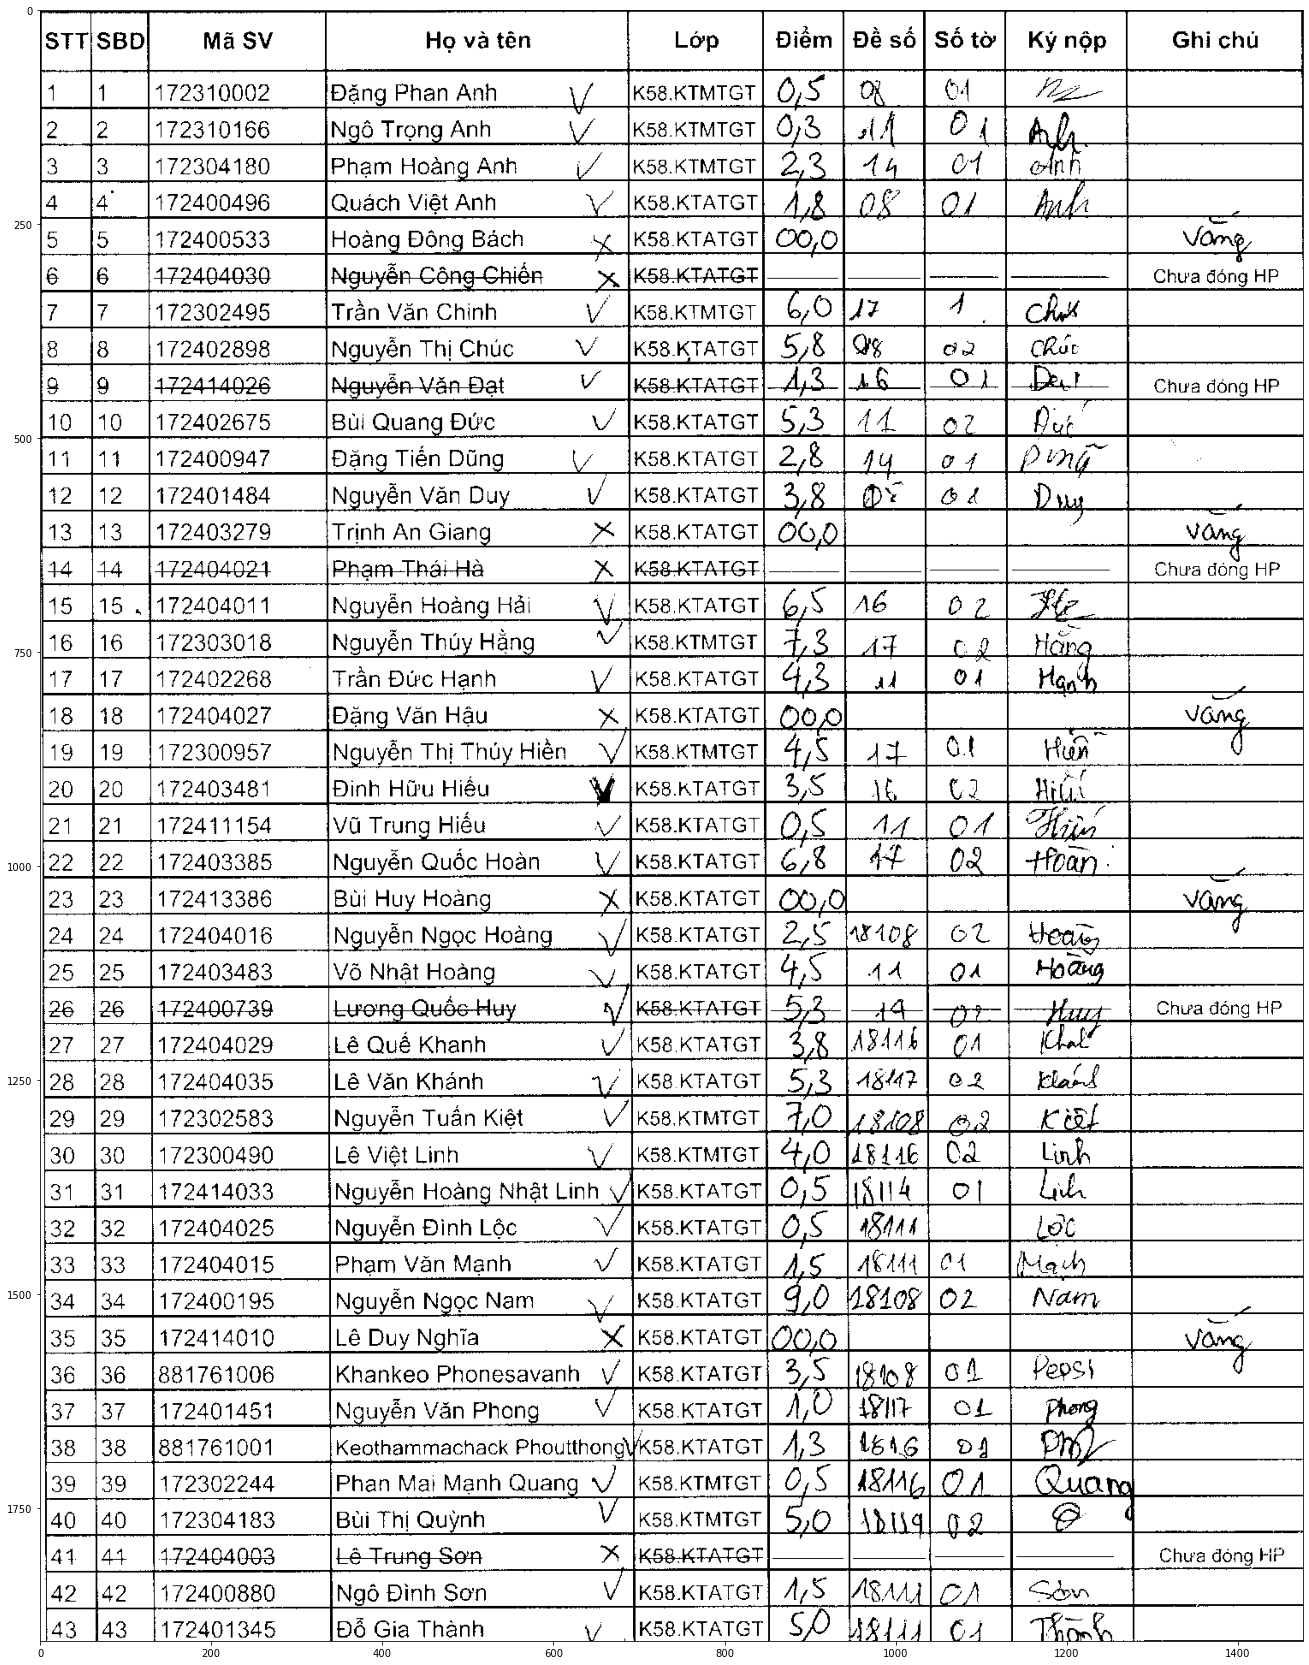

In [348]:
plt.figure(figsize=(36,30))
plt.imshow(areabd,cmap=cm.gray)
plt.show()

In [257]:
ths=2

In [281]:
df=compute_cross(a=5,b=image.shape[0]-5,c=5,d=image.shape[1]-5,w=10,im=image,th=ths)

IndexError: index 1664 is out of bounds for axis 1 with size 1654

In [267]:
df.head()

0     1
0  109  1184
1  109  1185
2  109  1186
3  109  1406
4  109  1407

In [268]:
df.values.min(axis=0)

array([109, 135], dtype=int64)

In [269]:
df.values.max(axis=0)

array([2291, 1480], dtype=int64)

In [279]:
area=image[109:2291,135:1480]

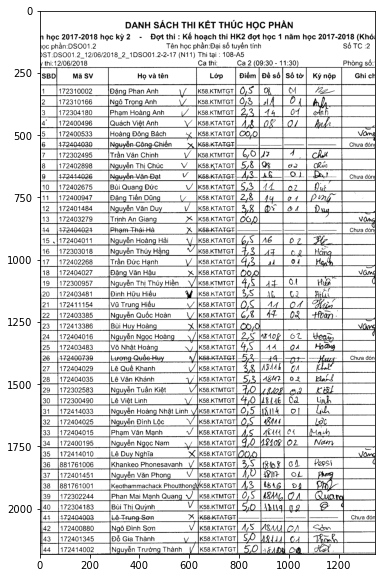

In [280]:
plt.figure(figsize=(6,10))
plt.imshow(area,cmap=cm.gray)
plt.show()

In [77]:
def computing_marks_studentid(page):
    image=convert_to_image_gray(page)
    (nrows,ncols)=image.shape
    binary=convert_to_binary(image)
    window=40 # threshold 
    ths=2 #threshold
    (a,b,c,d)=(150,nrows-window,900,1100)
    marks_cell=computing_cells(a,b,c,d,window,binary,ths)
    (a,b,c,d)=(150,nrows-window,175,450)
    students_id=computing_cells(a,b,c,d,window,binary,ths)
    return (binary,image,marks_cell,students_id)

In [233]:
(binary,img,marks_cell,id_cell)=computing_marks_studentid(pages[1])

In [234]:
len(id_cell)

15

In [80]:
len(marks_cell)

44

In [253]:
image=convert_to_image_gray(pages[1])## np.array

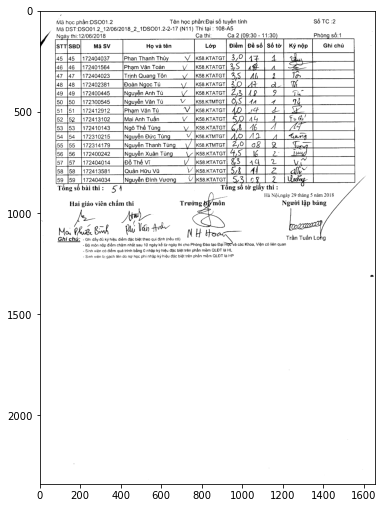

In [254]:
plt.figure(figsize=(6,10))
plt.imshow(image,cmap=cm.gray)
plt.show()

In [83]:
## display ID_student
def plot_student_id(idcell):
    xl=idcell[1][1].astype(int)
    xr=idcell[1][0].astype(int)
    yl=idcell[0][1].astype(int)
    yr=idcell[0][0].astype(int)
    plt.figure(figsize=(6,10))
    plt.imshow(image[xl:xr,yl:yr],cmap=cm.gray)
    plt.savefig('studentid.png')
    plt.show()

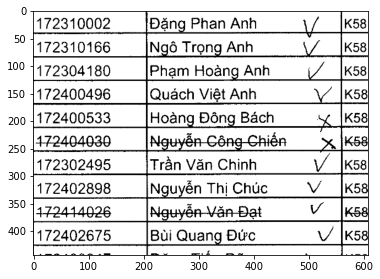

In [252]:
plot_student_id(id_cell[14])

In [85]:
## display Mark 
def plot_mark(markcell):
    xl=markcell[0,0].astype(int)
    xr=markcell[1,0].astype(int)
    yl=markcell[0,1].astype(int)
    yr=markcell[1,1].astype(int)
    plt.figure(figsize=(6,10))
    plt.imshow(image[xl:xr,yl:yr],cmap=cm.gray)
    plt.savefig('studentmarks.png')
    plt.show()

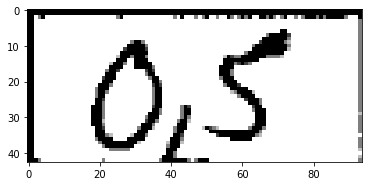

In [59]:
plot_mark(marks_cell[0])

## Segmentation Student ID

In [95]:
idcell=id_cell[0]
xl=idcell[1][1].astype(int)
xr=idcell[1][0].astype(int)
yl=idcell[0][1].astype(int)
yr=idcell[0][0].astype(int)

studentid=image[xl+5:xr-5,yl+5:yr-5]

In [96]:
studentid.shape

(32, 197)

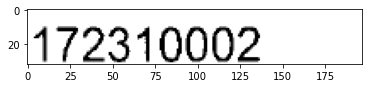

In [207]:
plt.imshow(studentid,cmap=cm.gray)

In [107]:
student_id_range=studentid.max(axis=0)-studentid.min(axis=0)

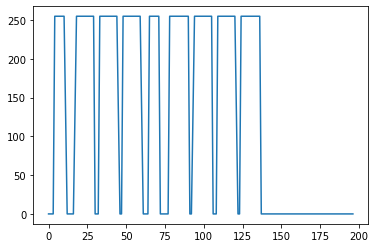

In [108]:
plt.plot(student_id_range)

In [113]:
student_id_range

array([  0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 128,   0,
         0,   0,   0,   0, 128, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255,   0,   0,   0, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 128,   0,   0, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 128,   0,   0,   0,   0,
       255, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         0,   0, 128, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 128,   0,   0, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [110]:
from scipy.signal import argrelextrema

In [114]:
# for local minima
minimums=argrelextrema(student_id_range, np.less)
print(minimums)

(array([], dtype=int64),)


In [115]:
from numpy import *

In [116]:
data=student_id_range

In [117]:
# that's the line, you need:
#a = diff(sign(diff(data))).nonzero()[0] + 1 # local min+max
b = (diff(sign(diff(data))) > 0).nonzero()[0] + 1 # local min
#c = (diff(sign(diff(data))) < 0).nonzero()[0] + 1 # local max

In [118]:
b

array([  3,  12,  16,  30,  32,  46,  47,  61,  64,  72,  77,  91,  92,
       106, 108, 122, 123, 137], dtype=int64)

In [141]:
cutoff=[]
cutoff.append(b[0])
for i in range(0,len(b)-1):
    if(b[i+1]-b[i]<=5):
        mid=(b[i]+b[i+1])/2;
        #print(np.int(mid))
        cutoff.append(np.int(mid))
cutoff.append(b[len(b)-1])
print(cutoff)

[3, 14, 31, 46, 62, 74, 91, 107, 122, 137]


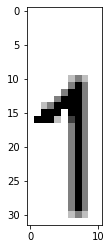

In [208]:
plt.figure()
plt.imshow(studentid[:,cutoff[0]:cutoff[1]],cmap=cm.gray)
plt.show()

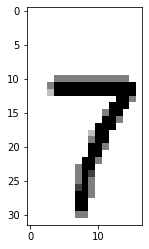

In [209]:
plt.figure()
plt.imshow(studentid[:,cutoff[1]:cutoff[2]],cmap=cm.gray)
plt.show()

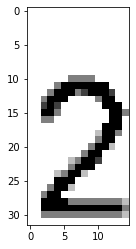

In [210]:
plt.figure()
plt.imshow(studentid[:,cutoff[2]:cutoff[3]],cmap=cm.gray)
plt.show()

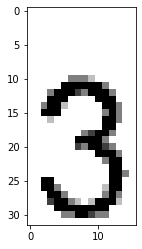

In [211]:
plt.figure()
plt.imshow(studentid[:,cutoff[3]:cutoff[4]],cmap=cm.gray)
plt.show()

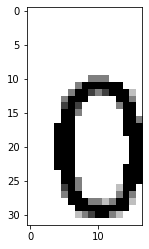

In [212]:
plt.figure()
plt.imshow(studentid[:,cutoff[5]:cutoff[6]],cmap=cm.gray)
plt.show()

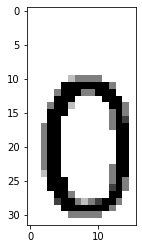

In [213]:
plt.figure()
plt.imshow(studentid[:,cutoff[6]:cutoff[7]],cmap=cm.gray)
plt.show()

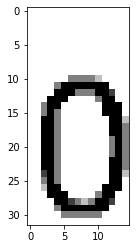

In [214]:
plt.figure()
plt.imshow(studentid[:,cutoff[7]:cutoff[8]],cmap=cm.gray)
plt.show()

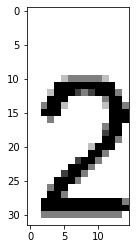

In [215]:
plt.figure()
plt.imshow(studentid[:,cutoff[8]:cutoff[9]],cmap=cm.gray)
plt.show()

## segmentation marks

In [198]:
markcell=marks_cell[34]
xl=markcell[0,0].astype(int)
xr=markcell[1,0].astype(int)
yl=markcell[0,1].astype(int)
yr=markcell[1,1].astype(int)

mark=image[xl+2:xr-2,yl+2:yr-2]

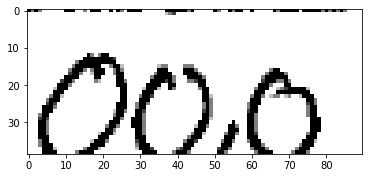

In [216]:
plt.imshow(mark,cmap=cm.gray)

In [230]:
mark_range=mark.max(axis=0)-mark.min(axis=0)
#mark_range=mark.std(axis=0)

In [231]:
mark_range.mean()

232.36666666666667

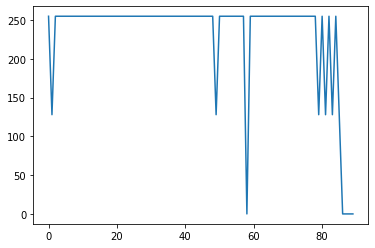

In [232]:
plt.plot(mark_range)

In [227]:
# that's the line, you need:
a = (diff(sign(diff(mark_range))) > 0).nonzero()[0] + 1 # local min

In [228]:
a

array([ 1,  7,  9, 11, 14, 21, 23, 27, 36, 40, 45, 50, 58, 61, 65, 68, 71,
       79, 81, 83, 86], dtype=int64)

In [203]:
cut=[]
#cut.append(a[0])
for i in range(0,len(a)-1):
    if(a[i+1]-a[i]>6):
        mid=[a[i],a[i+1]];
        #print(np.int(mid))
        cut.append(mid)
#cut.append(a[len(a)-1])
print(cut)

[[1, 49], [49, 58], [58, 79]]


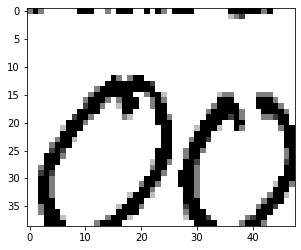

In [217]:
plt.figure()
plt.imshow(mark[:,cut[0][0]:cut[0][1]],cmap=cm.gray)
plt.show()

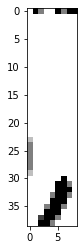

In [218]:
plt.figure()
plt.imshow(mark[:,cut[1][0]:cut[1][1]],cmap=cm.gray)
plt.show()

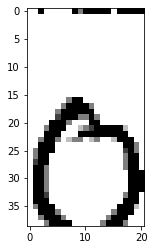

In [219]:
plt.figure()
plt.imshow(mark[:,cut[2][0]:cut[2][1]],cmap=cm.gray)
plt.show()

In [2]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

In [51]:
markcell=id_cell[0]
xl=markcell[0,0].astype(int)
xr=markcell[1,0].astype(int)
yl=markcell[0,1].astype(int)
yr=markcell[1,1].astype(int)
studentid=image[xl:xr,yl:yr]

In [54]:
#plt.imshow(studentid)

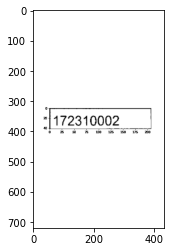

In [69]:
im = cv2.imread("studentid.png")
bbox, label, conf = cv.detect_common_objects(im)
output_image = draw_bbox(im, bbox, label, conf)
plt.imshow(output_image)
plt.show()

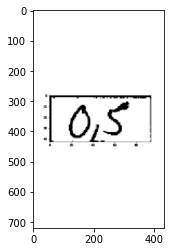

In [68]:
im = cv2.imread("studentmarks.png")
bbox, label, conf = cv.detect_common_objects(im)
output_image = draw_bbox(im, bbox, label, conf)
plt.imshow(output_image)
plt.show()

### Image Segmentation based on Clustering

In [11]:
studentid = cv2.imread("studentid.png")

In [12]:
# convert the image to grayscale format
img_gray = cv2.cvtColor(studentid, cv2.COLOR_BGR2GRAY)


In [16]:
# apply binary thresholding
ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
# visualize the binary image
cv2.imshow('Binary image', thresh)
cv2.waitKey(0)

cv2.imwrite('image_thres1.jpg', thresh)
cv2.destroyAllWindows()


In [23]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(imgage=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
# draw contours on the original image
image_copy = img_gray.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
# see the results
cv2.imshow('None approximation', image_copy)
cv2.waitKey(0)
cv2.imwrite('contours_none_image1.jpg', image_copy)
cv2.destroyAllWindows()


error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'findContours'
> Overload resolution failed:
>  - findContours() missing required argument 'image' (pos 1)
>  - findContours() missing required argument 'image' (pos 1)


In [27]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=img_gray,mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

In [47]:
print(contours[0].max(axis=0))
print(contours[0].min(axis=0))

[[240  58]]
[[0 0]]


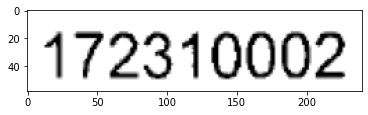

In [71]:
plt.imshow(studentid[0:58,0:240])

In [59]:
print(contours[1].max(axis=0))
print(contours[1].min(axis=0))

[[145  49]]
[[142  46]]


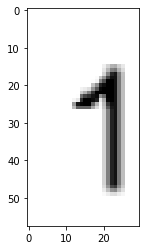

In [73]:
plt.imshow(studentid[0:58,0:30])

In [74]:
plt.imshow(studentid[0:58,0:30])

[[[92 47]]

 [[93 46]]

 [[94 46]]

 [[95 47]]

 [[94 48]]

 [[93 49]]

 [[92 48]]]


In [68]:
cv2.drawContours(image=image_copy, contours=contours[1], contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
cv2.imwrite('contours_image_contour.jpg', image_copy)

True

In [21]:
# draw contours on the original image
image_copy = img_gray.copy()

cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
# see the results


cv2.imwrite('contours_image2.jpg', image_copy)
cv2.destroyAllWindows()

13

In [83]:
pic_n = im.reshape(im.shape[0]*im.shape[1], im.shape[2])
pic_n.shape

(311040, 3)

In [84]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

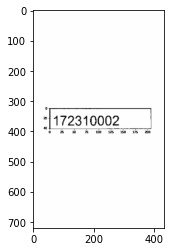

In [85]:
cluster_pic = pic2show.reshape(im.shape[0], im.shape[1], im.shape[2])
plt.imshow(cluster_pic)

In [86]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

### Segmentation Marks

## Convert Student ID to list of number

In [272]:
def split_student_id(id_binary,id_image):
    img=id_binary[5:-5,5:-5]
    
    labels = measure.label(img,background=1)
    props = regionprops(labels)
    student_number=[]  
    for i in range(len(props)):
        xmin,ymin,xmax,ymax=props[i].bbox
        xmat=id_image[xmin+5:xmax+5,ymin+5:ymax+5]
        xmat=resize(xmat,(20,10),preserve_range=True,order=3,cval=255).astype(int)
        student_number.append(xmat)
    return student_number 

In [315]:
def digital_number(idc,idbin,idimg):
    number_list=[]
    for i in range(len(idc)):
        c1=idc[i,0].astype(int)
        c2=idc[i,1].astype(int)
        id_binary=idbin[c1[0]:c2[0],c1[1]:c2[1]]
        id_image=idimg[c1[0]:c2[0],c1[1]:c2[1]]
        student_number=split_student_id(id_binary,id_image)
        for j in range(len(student_number)):
            number_list.append(student_number[j])
        #number_list=number_list+student_number
    return number_list   

In [288]:
numbers=digital_number(id_cell,binary,img)

C:\Users\tvlon\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [293]:
len(numbers)

357

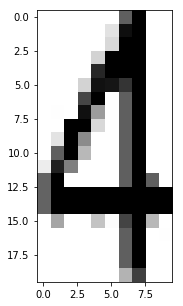

In [291]:
x=numbers[31]
plt.figure(figsize=(5, 5))
plt.imshow(x,cmap=cm.gray)
plt.show()

# Resize mark cell

In [263]:
def marks_resize(marks_cell, img):
    mark=[]
    for i in range(len(marks_cell)):
        c1=marks_cell[i,0].astype(int)
        c2=marks_cell[i,1].astype(int)
        mark_image=img[c1[0]:c2[0],c1[1]:c2[1]]
        x=resize(mark_image,(40,90),preserve_range=True,order=3,cval=255).astype(int)
        mark.append(x)
    return mark
marks=marks_resize(marks_cell,img)

C:\Users\tvlon\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


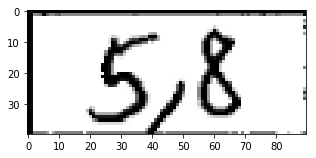

In [271]:
x=marks[7]
#x=resize(mark_image[3:-3,3:-3],(40,80),preserve_range=True,order=3,cval=255).astype(int)
plt.figure(figsize=(5, 5))
plt.imshow(x,cmap=cm.gray)
plt.show()

## Computing all digital students ID and Marks

In [327]:
import pickle

In [348]:
numbers=[]
marks=[]

#for i in range(len(pages)): error 12
i=14
print(i)
(bi,im,markc,idc)=computing_marks_studentid(pages[i])
marks=marks_resize(markc,im)
    #numbers=digital_number(idc,bi,im)   
    #with open('diem.pkl', 'wb') as fm:  
    # store the data as binary data stream
    #    pickle.dump(marks,fm)

14


C:\Users\tvlon\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
'''
    with open('diem.pkl', 'wb') as fm:  
    # store the data as binary data stream
        pickle.dump(marks,fm)

    with open('digitals.pkl', 'wb') as fd:  
    # store the data as binary data stream
        pickle.dump(numbers,fd)
'''

In [326]:
# load additional module
import pickle
with open('diem.pkl', 'wb') as fm:  
    # store the data as binary data stream
    pickle.dump(marks,fm)
with open('digitals.pkl', 'wb') as fd:  
    # store the data as binary data stream
    pickle.dump(numbers,fd)

In [347]:
len(marks)

4

In [341]:
len(numbers)

31

In [335]:
456/44

10.363636363636363

In [ ]:
# load additional module
import pickle

# define a list of places
placesList = ['Berlin', 'Cape Town', 'Sydney', 'Moscow']

with open('listfile.data', 'wb') as f:  
    # store the data as binary data stream
    pickle.dump(placesList, filehandle)

# load additional module
import pickle

with open('listfile.data', 'rb') as filehandle:  
    # read the data as binary data stream
    placesList = pickle.load(filehandle)

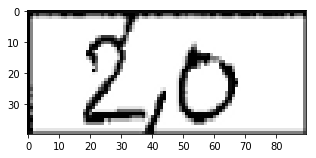

In [308]:
x=marks[300]
#x=resize(mark_image[3:-3,3:-3],(40,80),preserve_range=True,order=3,cval=255).astype(int)
plt.figure(figsize=(5, 5))
plt.imshow(x,cmap=cm.gray)
plt.show()

In [ ]:
import pickle

# write python dict to a file
mydict = {'a': 1, 'b': 2, 'c': 3}
output = open('myfile.pkl', 'wb')
pickle.dump(mydict, output)
output.close()
print mydict

# read python dict back from the file
pkl_file = open('myfile.pkl', 'rb')
mydict = pickle.load(pkl_file)
pkl_file.close()
print mydict

# update dict and write to the file again
mydict.update({'d': 4})
output = open('myfile.pkl', 'wb')
pickle.dump(mydict, output)
output.close()

# read python dict back from the file
pkl_file = open('myfile.pkl', 'rb')
mydict = pickle.load(pkl_file)
pkl_file.close()
print mydict

## Segmentation Student ID

In [ ]:
#(binary,img,marks_cell,id_cell)

In [148]:
i=1
c1=id_cell[i,0].astype(int)
c2=id_cell[i,1].astype(int)
id_bin=binary[c1[0]:c2[0],c1[1]:c2[1]]
id_img=img[c1[0]:c2[0],c1[1]:c2[1]]

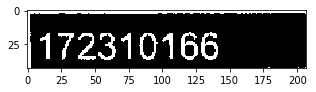

In [149]:
x=1-id_bin#[3:-3,3:-3]
plt.figure(figsize=(5, 5))
plt.imshow(x,cmap=cm.gray)
plt.show()

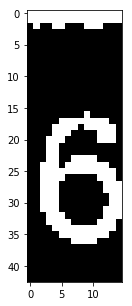

In [150]:
width=15
offset=7
plt.figure(figsize=(20, 5))
i=8
plt.imshow(x[:,offset+i*width:offset+(i+1)*width],cmap=cm.gray)
plt.show()

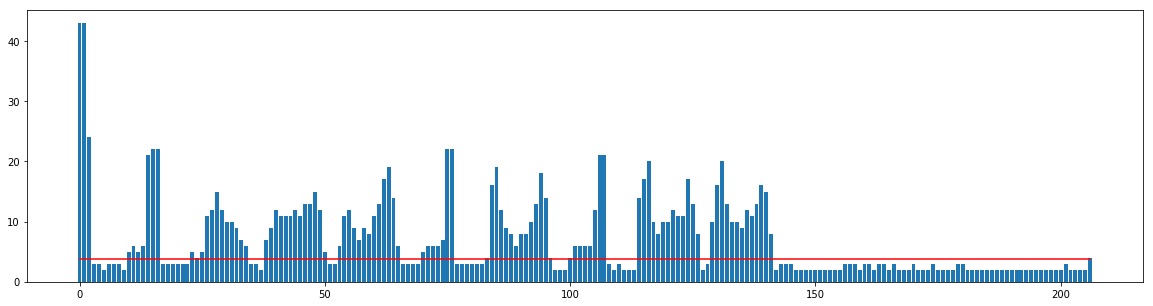

In [151]:
plt.figure(figsize=(20, 5))
plt.bar(range(x.shape[1]),x.sum(axis=0))
mu=x.sum(axis=0).mean()
sigma=x.sum(axis=0).std()
threshold=mu-0.5*sigma
plt.plot(range(x.shape[1]),[threshold]*(x.shape[1]),c='red')
plt.show()

In [65]:
x.shape

(42, 207)

In [88]:
sumx=np.count_nonzero(x,axis=0)

In [67]:
diffx=np.diff(sumx)

In [68]:
diffx

array([  0, -37,  -3,   0,   0,   0,   0,   0,   1,   1,   1,   0,   0,
        16,   2,  -2, -19,   0,   0,   0,   0,   1,   2,   0,   0,   8,
         1,   0,  -3,   0,  -2,   0,  -2,  -2,  -3,   0,   0,   8,   2,
         1,  -2,   0,   0,   0,   1,   0,   1,   0,  -3,  -6,  -2,   0,
         4,   4,   0,  -1,  -1,   1,   1,  -1,   3,   6,   0,  -6,  -9,
        -1,   0,   0,   0,   3,   0,   0,   0,   5,  12,   1, -21,   0,
         0,   0,   0,   0,   7,   8,   2,  -7,  -4,   0,   0,  -1,   0,
         2,   7,   1,  -5, -10,   0,   7,   6,   4,  -7,  -3,  -1,  -1,
         1,   0,  -1,   9,   2,  -3, -13,   0,   0,  12,   3,   4, -11,
        -2,   1,  -2,   2,   1,   2,   8,  -5,  -5,  -8,   0,   5,   4,
         2,   0,  -1,   1,  -1,   0,   0,   2,   2,  -2,  -6,  -6,   0,
         0,   0,   1,   0,  -1,   0,   0,   0,   0,   1,  -1,   0,   0,
         1,   0,   0,  -1,   0,   0,   0,   1,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  -

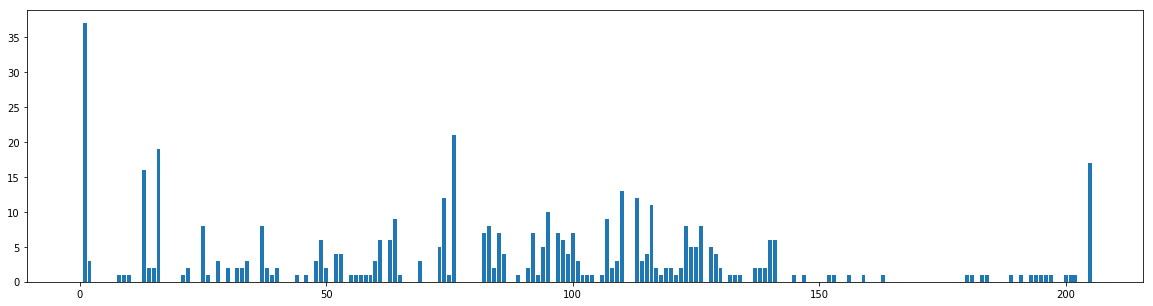

In [69]:
plt.figure(figsize=(20, 5))
plt.bar(range(len(diffx)),np.abs(diffx))
plt.show()

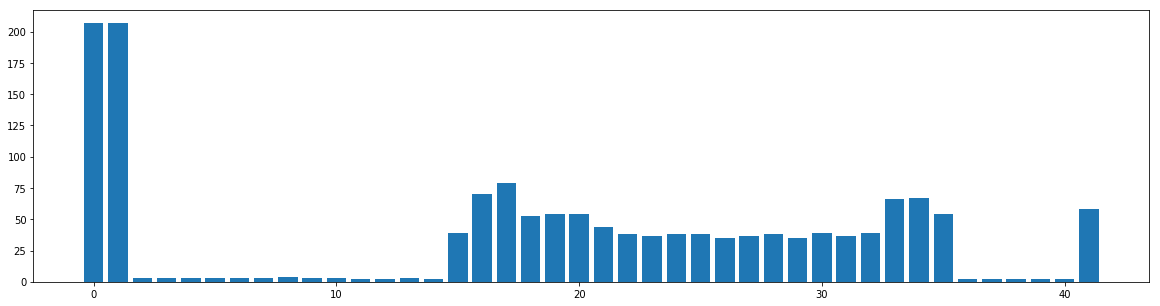

In [51]:
width=13
plt.figure(figsize=(20, 5))
plt.imshow(x[],cmap=cm.gray)
plt.show()

In [89]:
sumx

array([42, 42,  5,  2,  2,  2,  2,  2,  2,  3,  4,  5,  5,  5, 21, 23, 21,
        2,  2,  2,  2,  2,  3,  5,  5,  5, 13, 14, 14, 11, 11,  9,  9,  7,
        5,  2,  2,  2, 10, 12, 13, 11, 11, 11, 11, 12, 12, 13, 13, 10,  4,
        2,  2,  6, 10, 10,  9,  8,  9, 10,  9, 12, 18, 18, 12,  3,  2,  2,
        2,  2,  5,  5,  5,  5, 10, 22, 23,  2,  2,  2,  2,  2,  2,  9, 17,
       19, 12,  8,  8,  8,  7,  7,  9, 16, 17, 12,  2,  2,  9, 15, 19, 12,
        9,  8,  7,  8,  8,  7, 16, 18, 15,  2,  2,  2, 14, 17, 21, 10,  8,
        9,  7,  9, 10, 12, 20, 15, 10,  2,  2,  7, 11, 13, 13, 12, 13, 12,
       12, 12, 14, 16, 14,  8,  2,  2,  2,  2,  3,  3,  2,  2,  2,  2,  2,
        3,  2,  2,  2,  3,  3,  3,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,  2,  3,  3,
        3,  3,  3,  2,  2,  3,  3,  2,  3,  2,  3,  2,  2,  2,  3,  2,  3,
        3,  3, 20], dtype=int64)

In [107]:
w=5
std_shift=[]
for i in range(w,len(sumx)-w): 
    a=sumx[i:i+w]
    std_shift.append(a.std())


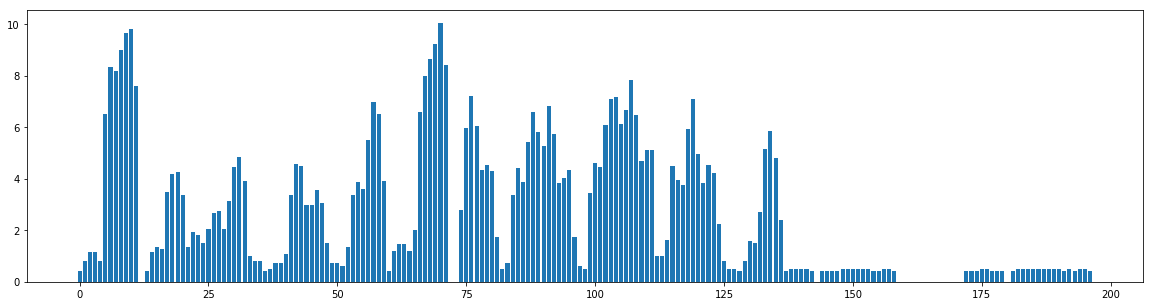

In [108]:
plt.figure(figsize=(20, 5))
plt.bar(range(len(std_shift)),std_shift)
plt.show()